# Dependencies

**IMPORTANT!**

To install necessary dependencies to the Google Colab VM this notebook runs in, please **run all cells in this section before doing anything else**.

In [ ]:
# download necessary libraries
!wget http://downloads.sourceforge.net/project/ltl3ba/ltl3ba/1.1/ltl3ba-1.1.3.tar.gz
!wget https://downloads.sourceforge.net/project/buddy/buddy/BuDDy%202.4/buddy-2.4.tar.gz
!wget https://netlib.org/voronoi/triangle.zip

In [ ]:
# build buddy library
!tar xzf buddy-2.4.tar.gz
%cd buddy-2.4
!./configure
!make
!make install
%cd ..

import os
os.environ['LD_LIBRARY_PATH']+='/content/buddy-2.4/src/.libs/'


In [ ]:
# unpack ltl3ba
!tar xzf ltl3ba-1.1.3.tar.gz

# build it
%cd ltl3ba-1.1.3/
!sed -i '36s#.*#BUDDY_INCLUDE=/content/buddy-2.4/src/#' Makefile
!sed -i '38s#.*#BUDDY_LIB=/content/buddy-2.4/src/.libs/#' Makefile
!make
%cd ..

# set the dynamic library path
import os
os.environ['LD_LIBRARY_PATH']='/content/buddy-2.4/src/.libs/'

In [ ]:
# unpack triangle
!mkdir triangle
!unzip "/content/triangle.zip" -d "/content/triangle"

# build it
%cd triangle/
!make
%cd ..

# Tutorial 3: Discrete Planning

This tutorial focusses on exploring basic concepts of high-level task planning via Linear Temporal Logic (LTL) specifications on discrete models of the environment.

Throughout the tutorial, we will be using the example of an autonomous system navigating through a bounded workspace, shown in a top-down perspective. In this 2D representation of the workspace, we define static obstacles or abstract regions of interest through polygons.

We assume the autonomous system is able to move freely in this workspace. Specifically, this tutorial does not reason over the dynamics of that autonomous system. Imagine the scale of this environment to be large enough for the actual dynamics to be insignificant.

<div>
    <img src="https://drive.google.com/uc?id=1zgE4SLqFQhrgkUesslMQbacNtlpElgfs" width="400"/>
</div>


# E-Level

In this section, we will:

*   create a discrete, finite-state representation of an environment
*   use state-of-the-art tools to translate LTL formulae into Büchi-Automata
*   combine the two to find a path in the environment that satisfies our LTL formula



## Workspace Model

In order to facilitate high-level planning, we will create a **finite** and **discrete** representation of our workspace, namely a **transition system**.

### Theory - Transition Systems
In the following sections, you will discretize our continuous workspace model into a transition system.

Formally, a labelled transition system is defined as a tuple

$$T=(S, Act, \xrightarrow{}, s_0, \mathit{AP}, L)$$
where
* $S$ is a finite set of states,
* $Act$ is a finite set of inputs,
* $\xrightarrow{} : S \times Act \times S$ is the transition function,  
* $s_0$ is the initial state,
* $\mathit{AP}$ is a finite set of atomic propositions and
* $L : S \xrightarrow{} 2^{\mathit{AP}}$ is a state labeling function.

Here, we have an abstract example of a transition system with four states $s_0$ to $s_3$ depicted as circles. The initial state $s_0$ is marked with an incoming arrow. Each arrow between two states is a transition captured by the transition function, like $\delta(s_3, act_1) = s_2$ or $\delta(s_3, act_2) = s_1$. In each state, you choose an action to perform and the transition system changes state accordingly.

Each state is labelled by the labelling function $L$, which assigns to a state the atomic propositions which hold true in that state. $L(s_0) = \{a,b\}$ meaning that both $a$ and $b$ hold true in that state.

![image](https://drive.google.com/uc?id=1gCagi27t9RC57qXQWef7BQb1RRdP1m1K)


### Theory - Paths and Traces

* An (infinite) **path** $\pi$ on a transition system is a sequence of states $s_0s_1s_2 \dots$ such that $s_0$ is the initial state and $\forall i\geq 0 \;: \exists a \in Act: s_{i+1} \in \delta(s_i, a)$.

* A **trace** of a given path $\pi = s_0s_1s_2\dots$ is the sequence of labels $\tau(\pi)=L(s_0)L(s_1)L(s_2)\dots$.

* The traces of a transition system are thus (infinite) words on the alphabet $2^{\mathit{AP}}$.

### Workspace Definition

First, let's define the workspace. We assume a rectangular subset of $\mathbb{R}^2$ with so-called regions of interest defined as 2D polygons. We define the polygons through their vertices. Some of the regions are static obstacles, which we will cut out from our representation. Those regions have a `self.hole` defined during construction. You can also see that the regions have a `self.cost_per_unit` attribute, but you can ignore that for the E-level.

In [42]:
from shapely.geometry import Polygon, Point

default_cost_per_unit = 1

class RegionOfInterest:
  def __init__(self, name, points, hole=None, cost_per_unit=default_cost_per_unit):
    self.name = name
    self.points = points
    self.hole = hole
    self.poly = Polygon(points)
    self.cpu = cost_per_unit

  def contains(self, x, y):
    result = self.poly.contains(Point(x, y))
    if isinstance(result, bool):
      return result
    else:
      return result[0]

# define workspace bounds
xmin = 0
xmax = 10
ymin = 0
ymax = 10

# define regions of interest
rois = [
    RegionOfInterest(
        name="staircase",
        points=[(0,10), (3,10), (3,8), (0,8)],
        hole=(1.5,9)
    ),
    RegionOfInterest(
        name="charge",
        points=[(3,9), (3,10), (4,10), (4,9)],
    ),
    RegionOfInterest(
        name="wall1",
        points=[(6,4), (6,5), (9,5), (9,4)],
        hole=(8,4.5)
    ),
    RegionOfInterest(
        name="wall2",
        points=[(4,1), (4,4), (5,4), (5,1)],
        hole=(4.5,2)
    ),
    RegionOfInterest(
        name="wall3",
        points=[(2,4), (2,5), (5,5), (5,4)],
        hole=(3.5,4.5)
    ),
    RegionOfInterest(
        name="wall4",
        points=[(0,4), (0,5), (1,5), (1,4)],
        hole=(0.5,4.5)
    ),
    RegionOfInterest(
        name="wall5",
        points=[(6,5), (6,9), (7,9), (7,5)],
        hole=(6.5,7)
    ),
    RegionOfInterest(
        name="rooma",
        points=[(0,0), (0,4), (4,4), (4,0)],
    ),
    RegionOfInterest(
        name="roomb",
        points=[(7,5), (7,10), (10,10), (10,5)],
    ),
    RegionOfInterest(
        name="roomc",
        points=[(5,0), (5,4), (10,4), (10,0)],
    ),

]

In order to create a discrete, finite representation of this workspace, we create a triangulation of the workspace. To accomplish this, we use the triangulation library [Triangle](https://www.cs.cmu.edu/~quake/triangle.html).

#### Triangle Parsing Functions

In this section are the functions required to write and parse our data into and out of files compatible with the Triangle library. You do not need to deeply understand these, but feel free to take a look!

In [6]:
"""
CREATE INPUT FILES READABLE BY TRIANGLE
"""
# creates a .poly file from workspace and obstacles according to https://www.cs.cmu.edu/~quake/triangle.poly.html
def workspace_to_poly_file(xmin, xmax, ymin, ymax, regions):
  # vertices of the mesh - workspace corners and obstacle points
  num_vert = 4 + sum( [ len(reg.points) for reg in regions])
  vert_header = "#vertices\n%i 2 0 0\n"%num_vert
  vert_str = "0 %i %i\n"%(xmin, ymin)
  vert_str += "1 %i %i\n"%(xmin, ymax)
  vert_str += "2 %i %i\n"%(xmax, ymax)
  vert_str += "3 %i %i\n"%(xmax, ymin)

  vert_id = 4
  for reg in regions:
    for (x,y) in reg.points:
      vert_str += "%i %f %f\n"%(vert_id, x, y)
      vert_id += 1

  # line segments that will be enforced in the triangulation
  num_seg = num_vert # since all shapes are closed
  seg_header = "#segments\n%i 0\n"%num_seg
  seg_str = "0 0 1\n1 1 2\n2 2 3\n3 3 0\n" # workspace bounds

  seg_id = 4
  vert_id = 4
  for reg in regions:
    for i in range(len(reg.points)):
      from_id = vert_id + i
      to_id = vert_id + i + 1 if i+1 < len(reg.points) else vert_id
      seg_str += "%i %i %i\n"%(seg_id, from_id, to_id)
      seg_id += 1
    vert_id += len(reg.points)

  # holes
  num_holes = 0
  hole_str = ""
  for reg in regions:
    if reg.hole is not None:
      hole_str += "%i %f %f\n"%(num_holes, reg.hole[0], reg.hole[1])
      num_holes += 1
  hole_header = "#holes\n%i\n"%num_holes

  with open("workspace.poly", "w") as f:
    f.write(vert_header + vert_str + seg_header + seg_str + hole_header + hole_str)

In [7]:
"""
PARSE TRIANGLE OUTPUT FILES
"""
import numpy as np

# assumes [file_name].1.node and [file_name].1.ele to exist
def parse_triangle(file_name="workspace"):
  vertices = []
  faces = []

  # read vertex positions
  with open(file_name+".1.node", encoding = 'utf-8') as f:
    # first line contains info about number of vertices etc, see: https://www.cs.cmu.edu/~quake/triangle.node.html
    first_line = next(f).strip().split()
    assert len(first_line) == 4
    assert first_line[1] == "2" # 2d vertices
    num_vert = int(first_line[0])
    for line in f:
      values = line.strip().split()
      if values[0].isnumeric():
        x = float(values[1])
        y = float(values[2])
        vertices.append((x,y))
    assert num_vert == len(vertices)

  # read face indices
  with open(file_name+".1.ele", encoding = 'utf-8') as f:
    # first line contains info about number of vertices etc, see: https://www.cs.cmu.edu/~quake/triangle.ele.html
    first_line = next(f).strip().split()
    assert len(first_line) == 3
    assert first_line[1] == "3" # each triangle has 3 nodes
    num_face = int(first_line[0])

    for line in f:
      values = line.strip().split()
      if values[0].isnumeric():
        assert len(values) == 4
        faces.append((int(values[1]), int(values[2]), int(values[3])))
    assert num_face == len(faces)

  return np.array(vertices), np.array(faces)

In [8]:
"""
CALL TRIANGLE
"""
import subprocess

def call_triangle(filename="workspace.poly", max_area=None):
  options = ["triangle/triangle", "-p", "-q", filename, "-D"]
  if max_area is not None:
    options.insert(1, "-a%f"%max_area)
  subprocess.run(options)

In [9]:
"""
VIZUALIZE RESULTS
"""
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
import matplotlib.patches as pt

def centroid(points):
  x = 0
  y = 0
  for p in points:
    assert len(p) == 2
    x += p[0]
    y += p[1]
  x /= len(points)
  y /= len(points)
  return (x, y)

def normalized_alpha_by_cost(points, rois, max_cost):
  default_alpha = 0.4 #@param {type:"slider", min:0.0, max:1.0, step:0.1}
  min_cost = 1
  min_alpha = 0.1 #@param {type:"slider", min:0.0, max:1.0, step:0.1}
  max_alpha = 0.7 #@param {type:"slider", min:0.0, max:1.0, step:0.1}
  # if all costs are the same
  if max_cost == min_cost:
    return default_alpha
  # find cost of this face
  cost = None
  for roi in rois:
    x,y = centroid(points)
    if roi.contains(x,y):
      cost = roi.cpu
      break
  # does not belong to a region of interest, default cost
  if cost is None:
    return min_alpha
  # otherwise linear map from cost in [min_cost, max_cost] to [min_alpha, max_alpha]
  alpha = (cost - min_cost)*(max_alpha-min_alpha)/(max_cost-min_cost) + min_alpha
  return alpha

def viz_mesh(vertices, faces, rois, highlight=[]):
  # find highest cost area
  highest_cost = 1
  for roi in rois:
    if roi.cpu > highest_cost:
      highest_cost = roi.cpu

  patches = []
  for (i, f) in enumerate(faces):
    # get coords for the face
    coords = np.zeros(6).reshape(3,2)
    for j in range(3):
      coords[j] = vertices[f[j]]
    # default faces are blue, path highlight is red, roi faces are yellow
    color = "b"
    if i in highlight:
      color = "r"
    else:
      for roi in rois:
        x,y = centroid(coords)
        if roi.contains(x,y):
          color = "y"
          break
    # depending on region cost, appropriate alpha is chosen
    alpha = normalized_alpha_by_cost(coords, rois, highest_cost)
    polygon = pt.Polygon(coords, closed=True, fill=True, facecolor=color, edgecolor=color, alpha=alpha)
    patches.append(polygon)

  fig, ax = plt.subplots()
  p = PatchCollection(patches, match_original=True)
  ax.add_collection(p)
  plt.scatter(vertices[:, 0], vertices[:, 1])
  plt.show()


### Calling Triangle



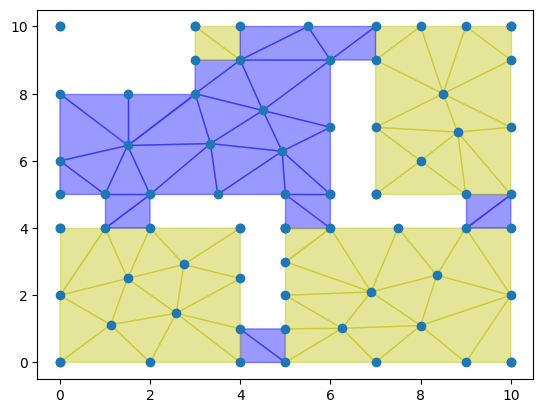

In [10]:
# create input file
workspace_to_poly_file(xmin, xmax, ymin, ymax, regions=rois)
# call triangle
max_area = 1.6 #@param {type:"slider", min:0.1, max:5.0, step:0.1}
call_triangle(max_area=max_area)
# parse output
vert, faces = parse_triangle()
# vizualize the result
viz_mesh(vert, faces, rois)

### Exercise - Creating the Transition System

Next, we will need to translate this mesh into a transition system. We will be using [NetworkX](https://networkx.org/) to represent our TS.

`vert` is a list of vertices. Each entry in the list represents a 2D point of the mesh.
`faces` is a list of faces (triangles). Each face is defined through three vertices. Each entry in the list is an index of the corresponding vertex in `vert`.

**Exercise:**
* Create a state for each face in `faces`
* Create transitions between neighbouring faces. This will represent the possibility to travel between these areas.

**Hints:**
* Two faces are adjacent if they share two vertices.
* If face a is adjacent to b, then b is also adjacent to a.
* Each face is "adjacent" to itself; The autonomous system can stay in an area.

In [11]:
"""
PRACTICE DIGRAPH --> EXAMPLE ONLY
"""
import networkx as nx
digraph_example = nx.DiGraph()
for id, face in enumerate(faces):
  digraph_example.add_node(id, face=face)
digraph_example.graph['vertices'] = vert
print("Example face/node in Nodes:", digraph_example.nodes[0])
print("Number of faces/nodes:", len(faces)) # changes depending on your settings
print("Complete node data:",digraph_example.nodes(data =True)) # setting data = False will list only the ids, setting data = True will also list the attribute and value
print("Example Vertex in Graph:", digraph_example.graph['vertices'][0]) # Iterate through them for labelling


Example face/node in Nodes: {'face': array([49, 67, 71])}
Number of faces/nodes: 84
Complete node data: [(0, {'face': array([49, 67, 71])}), (1, {'face': array([32, 46, 60])}), (2, {'face': array([59, 70, 53])}), (3, {'face': array([20, 55, 66])}), (4, {'face': array([27, 45, 55])}), (5, {'face': array([57, 72, 73])}), (6, {'face': array([55, 20, 27])}), (7, {'face': array([16, 35, 40])}), (8, {'face': array([21, 27, 20])}), (9, {'face': array([65, 66, 63])}), (10, {'face': array([60, 46, 63])}), (11, {'face': array([63, 35, 16])}), (12, {'face': array([62, 64, 61])}), (13, {'face': array([ 6, 47, 56])}), (14, {'face': array([21, 56, 26])}), (15, {'face': array([21, 26, 27])}), (16, {'face': array([11,  6, 58])}), (17, {'face': array([56, 47,  7])}), (18, {'face': array([ 7, 48, 56])}), (19, {'face': array([26, 48, 25])}), (20, {'face': array([57, 73, 12])}), (21, {'face': array([ 8,  6, 11])}), (22, {'face': array([ 5, 11, 10])}), (23, {'face': array([11,  5,  8])}), (24, {'face': arr

In [12]:
import networkx as nx
"""
E-PART
EXERCISE #1 : CREATING TRANSITION SYSTEM
"""
def ts_from_triang(vert, faces):
  # create a networkx directed graph, see https://networkx.org/documentation/stable/reference/classes/digraph.html
  ts = nx.DiGraph()
  for id, face in enumerate(faces):
    ts.add_node(id, face = face)

  # Add vertices to graph so that you can use the vertices values in the next exercise
  ts.graph['vertices'] = vert

  # Double forloop: for each node with attribute name face, see if at least two vertex indices are same (unordered)
  for node_a in ts.nodes:
    face_a = ts.nodes[node_a]['face'] # extract vertex indices
    for node_b in ts.nodes:
      face_b = ts.nodes[node_b]["face"] # extract vertex indices
      # count = sum(a == b for a, b in zip(face_a, face_b)) # if exact position would be required
      common_vertices = sum(val in face_b for val in face_a) # compare vertex indices

      #If any two vertices are the same, add an edge between the two nodes
      if common_vertices >= 2:
        ts.add_edge(node_a, node_b)

  return ts

ts = ts_from_triang(vert, faces)
assert(len(ts.nodes()) == len(faces))
print("Number of states:", len(ts.nodes()))
print("Number of transitions:", len(ts.edges()))

Number of states: 84
Number of transitions: 286


### Exercise - Labelling States

Next, we will define atomic propositions and label the states.

**Exercise:**
* Use the names of the regions of interest to define the atomic propositions $AP$.
* Label all states by checking in which regions of interest the face belongs to.
* Choose one the faces in `charge` as the initial state. Store it in `ts.graph["init"]`.

**Hints:**
* You can store information about the graph like so `ts.graph["key"] = some_cool_data`.
* You can store information about a specific node like so `ts.nodes[node]["labels"] = label_data`.
* Regions of interest can overlap.
* Regions of interest can have multiple faces.
* Each region of interest defined above has a `self.poly` attribute, which stores a [Shapely Polygon](https://shapely.readthedocs.io/en/stable/manual.html#polygons). You can use [the contains() method](https://shapely.readthedocs.io/en/stable/manual.html#object.contains) to check if a geometric shape or point is inside a polygon.


In [13]:
"""
E-PART
EXERCISE #2 : LABELLING STATES IN TRANSITION SYSTEM
"""
def label_ts(ts, rois):
  # manipulate the given TS, adding label information to states
  # save info on all possible labels
  # label the states

  # Label all the states according to the region. Label called "AP"
  for node in ts.nodes:
    face = ts.nodes[node]['face'] # extract face list containing indices of vertices belonging to its face
    # index out the vertices and create a polygon of all the vertices for one face (3 faces, 2 vertices each: 6 vertices)
    vertices = [ts.graph['vertices'][indx] for indx in face]
    poly_face = Polygon(vertices) # create polygon and check in which region its contained
    # node can have multiple regions
    ts.nodes[node]["AP"] = [] # create empty list for AP --> regions for each face // can be multiple regions
    for roi in rois:
      if roi.poly.contains(poly_face):
        ts.nodes[node]["AP"].append(roi.name)

  # Any node with AP as charge can be used for init
  for node in ts.nodes:
    for AP in ts.nodes[node]["AP"]:
      if AP == "charge":
        ts.graph["init"] = node

  # Initialize the graph with AP region names --> later also used for product automaton
  ts.graph["AP"] = []
  for roi in rois:
    ts.graph["AP"].append(roi.name)

  pass
#rois -> region of interest class with prooperties such as name, points, hole, poly, cpu
print([roi.name for roi in rois])
print(ts.graph['vertices'][0])
# print(ts.graph['AP'])
# print(ts.graph['init'])
print(ts[1])
print([neighbour for neighbour in ts.neighbors(1)])
print([successor for successor in ts.successors(1)])
print([predecessor for predecessor in ts.predecessors(1)])
label_ts(ts, rois)

['staircase', 'charge', 'wall1', 'wall2', 'wall3', 'wall4', 'wall5', 'rooma', 'roomb', 'roomc']
[0. 0.]
{1: {}, 10: {}, 27: {}}
[1, 10, 27]
[1, 10, 27]
[1, 10, 27]


### Visualizing the Transition System

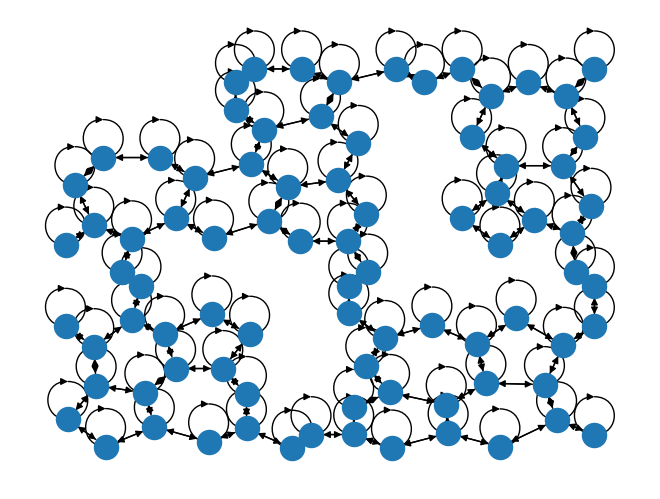

In [14]:
import networkx as nx
import matplotlib.pyplot as plt

# create a position for each state (center of face)
pos = {}
for i, face in enumerate(faces):
    points = []
    for fid in face:
      points.append(vert[fid])
    pos[i] = np.asarray(centroid(points))
nx.draw(ts, pos=pos)
plt.show()

## Specification Language

To specify the desired system behaviour, we use **Linear Temporal Logic (LTL)**. Originally proposed for the formal analysis of computer programs, LTL was introduced in 1977 by the computer scientist [Amir Pnueli](https://en.wikipedia.org/wiki/Amir_Pnueli)[1]. With LTL, we can encode formulae about the future of paths, e.g., a condition will eventually be true, a condition will be true until another fact becomes true, and so on.

### Theory - Linear Temporal Logic

LTL formulae are interpreted over linear, infinite execution traces, for example those produced by a transition system. Like in the transition system definition, $AP$ is a set of propositions.

$$
    \phi := true\;|\;
    a\;|\;
    \neg \phi\;|\;
    \phi_1 \wedge \phi_2\;|\;
    X \phi \;|\;
    \phi \, U \phi,
    \quad a \in \mathit{AP}
$$

The full power of propositional logic is obtained through the operators $\neg$ and $\wedge$. Operators $\vee, \xrightarrow{}, \leftrightarrow{}$ are defined as usual:
* $a \vee b \equiv \neg (\neg a \wedge \neg b)$
* $a \xrightarrow{} b \equiv \neg a \vee b$
* $a \leftrightarrow{} b \equiv (a \wedge b) \vee (\neg b \wedge \neg a)$

$X$ is the next-operator, representing something holding in the next step. $U$ is the until-operator, requiring $\phi_1$ to hold until $\phi_2$ holds. For our purposes, the temporal operators $F$ and $G$ are practical to use. They are defined like this:

* $F \phi=true\,U \phi$ represents $\phi$ holding **eventually** in the future and
* $G \phi = \neg F \neg\phi$ **always** holding from now on.

## LTL to Büchi-Automaton

One of the key benefits of LTL is that for any valid formula, you can construct a **Büchi Automaton** that exactly decides between the sequences of propositions that satisfy the formula and those that don't [2].

### Theory - Infinite Word Automata
An **Büchi automaton** over the alphabet $\Sigma$ is a tuple

$$A=(Q, \Sigma, \delta, q_0, F)$$
where:

* $Q$ is a finite set of states,
* $\Sigma$ is a finite set of symbols (in this tutorial always $\Sigma = 2^\mathit{AP}$,
* $\delta : Q \times \Sigma \xrightarrow{} 2^Q$ is a transition function,
* $q_0$ is the initial state, and
* $F \subseteq Q$ is a finite set of *accepting* states.


### Theory - Runs, Acceptance and Determinism

* A **run** of the infinite word automaton $A$ on a word $\sigma = \sigma_0\sigma_1\sigma_2\dots \in \Sigma^\omega$ is an infinite sequence of states $r = q_0q_1q_2\dots \in Q^\omega$ with $q_\mathit{ini}$ being the initial state and $\forall i \geq 0: q_{i+1} \in \delta(q_i, \sigma_i)$. Given a word $\sigma$, we define the set of all possible runs of $A$ on $\sigma$ as $\mathit{Runs}_A(\sigma)$.

* We say a run is **accepting** if it visits a state in $F$ infinitely often.

* We say the automaton **accepts** a word $\sigma$ if one of the runs in $\mathit{Runs}_A(\sigma)$ is accepting.

* When $|\delta(q, \sigma)| <= 1, \forall q \in Q, \forall \sigma \in \Sigma$, we call the automaton **deterministic**. As a consequence, $|\mathit{Runs}_A(\sigma)| <= 1, \forall \sigma \in \Sigma$. In the rest of this document, we abbreviate non-deterministic Büchi Automaton with **NBA**.

* When $|\delta(q, \sigma)| > 0, \forall q \in Q, \forall \sigma \in \Sigma$, we call the automaton **complete**.

You can imagine that we sequentially feed an infinite word into the Büchi automaton, symbol by symbol. The automaton takes the incoming next symbol and changes state accordingly. If there are multiple edges to take (non-determinism), we have to consider both options. If there is no option (non-completeness), the run simply is discarded. A word is accepted if one of the infinite paths visits an accepting state infinitely often.

As mentioned before, we can construct a NBA for every LTL formula $\phi$ such that the words that satisfy the the formula are exactly the words that get accepted by the the NBA.

### Automaton Construction via LTL3BA

To generate our NBA from a given LTL formula, we use [LTL3BA](https://sourceforge.net/projects/ltl3ba/) [3]. More on the theory behind the automaton construction can be found in [2].

LTL formulas are given as strings with the following formatting:
```
Propositonal Symbols:
  true, false
  any lowercase string
Boolean operators (no priority, use parentheses):
  !   (negation)
  ->  (implication)
  <-> (equivalence)
  &&  (and)
  ||  (or)
Temporal operators (no priority, use parentheses):
  G   (always)
  F   (eventually)
  U   (until)
  X   (next)
```
There is no guarantee that the generated automaton will be deterministic or complete. The result is parsed into a Networkx directed graph:
* `nba.graph["accept"]` stores the accepting states
* `nba.graph["init"]` stores the initial state
* `nba.edges[q1, q2]["guard"]`: Each edge has a boolean [SymPy](https://www.sympy.org/en/index.html) expression that represents when this edge can be taken
* You can evaluate SymPy expressions via `guard.subs({"a": True, "b": False})`


In [15]:
"""
PARSE LTL3BA OUTPUT
"""

import subprocess
import networkx as nx
import re
from sympy.parsing.sympy_parser import parse_expr

def ltl_to_nba(formula, print_ltl3ba=False):
  raw = subprocess.check_output(["ltl3ba-1.1.3/ltl3ba", "-f",  formula])
  lines = raw.decode('utf-8').split("\n")
  nba = nx.DiGraph()
  nba.graph["accept"] = []

  for line in lines:
    if print_ltl3ba:
      print(line)
    #we skip unnecessary lines
    if "never" in line or "}" in line or len(line) == 0:
      continue
    # this line is a state
    if line[0] != "\t":
      state = line.strip(":")
      nba.add_node(state)
      if "init" in state:
        nba.graph["init"] = state
      if "accept" in state:
        nba.graph["accept"].append(state)
    else:
      # edge descriptions
      if line[1] == ":":
        guard = re.search("\t:: (.*) -> goto", line).group(1).replace("||", "|").replace("&&", "&").replace("!", "~")
        parsed_guard = parse_expr(guard)
        # print(parsed_guard, parsed_guard.subs({"a": True, "b": False}))
        state_to = re.search("-> goto (.*)", line).group(1)
        nba.add_edge(state, state_to, guard=parsed_guard)
      # this state accepts all inputs - self loop with true guard
      if line == "\tskip":
        nba.add_edge(state, state, guard=parse_expr("True"))
  return nba

### Exercise - Büchi Automata

**Exercise:**
* Generate the Büchi Automaton for $\phi = F G \,a$.
* Examine the output. How many states does it have? How many edges?
* Is it deterministic? Why? Why not?
* Is it complete? Why? Why not?
* Give each one example of an (infinite) accepted word and a rejected word.

In [16]:
"""
E-PART
EXERCISE #3 : BÜCHI AUTOMATA
"""
# Use the function ltl_to_nba to generate the Buchi automaton
# Buchi automata are defined with acceptance conditions based on setss of states that must be visited infinitely often

formula = "FGa"
nba = ltl_to_nba(formula, print_ltl3ba=True)
print(f"# A-States: {len(nba.graph['accept'])}, A-States: {nba.graph['accept']}")
print(f"# Edges: {len(nba.edges)}, Edges:{nba.edges}")
print(f"Init: {nba.graph['init']}")
for edges in nba.edges:
  print(f"Guard: {nba.edges[edges]}")


never { /* FGa */
T0_init:
	if
	:: (1) -> goto T0_init
	:: (a) -> goto accept_S1
	fi;
accept_S1:
	if
	:: (a) -> goto accept_S1
	fi;
}

# A-States: 1, A-States: ['accept_S1']
# Edges: 3, Edges:[('T0_init', 'T0_init'), ('T0_init', 'accept_S1'), ('accept_S1', 'accept_S1')]
Init: T0_init
Guard: {'guard': 1}
Guard: {'guard': a}
Guard: {'guard': a}


Exercise Solution: <br>
The number of total states is 2. Number of accepting states is 1. <br>
The number of edges is 3. <br>
Deterministic?: No. If in T0_init, a can bring it to state T0_init or to accept_S1. So more than 2 paths for the same symbol exist.  <br>
Complete?: No, if choice of symbol includes "a" and more. -> Even though there exists a transition from every state to another, consider being in the accepting state accept_S1 and getting a symbol other than "a"; then no transition would exist and there would be no completeness.<br>
Example of an infinitely rejected word would be anything other than "a" repeated infinitely. <br>
Example of an infinitely accepted word would be "a" repeated infinitely. <br>

## Finding a Solution

To find a series of actions in the transition system $T$ such that the resulting trace satisfies $\phi$, we construct a **product automaton** that simultaneously keeps track of both $T$ and the Büchi Automaton $A$ created from $\phi$. Then, we will find a so-called **lasso path** on this product.

### Theory - Product Automaton

Given a transition system
$$T = (S,Act,\xrightarrow{},s_0,\mathit{AP},L)$$
and a NBA
$$A = (Q, 2^{\mathit{AP}}, \delta, q_0, F)$$
the product automaton is a tuple
$$P = (Q_p, \Sigma_p, \delta_p, q_{p,0}, F_p)$$
where:
* $Q_p \subseteq S \times Q$ is a finite set of states; Each state holds information about the current state of the transition system as well as the current state of the NBA,
* $\Sigma_p = \mathit{Act}$ is a finite set actions (directly from the transition system),
* $\delta_p : Q_p \times \mathit{Act} \xrightarrow{} 2^{Q_p}$ is a transition function (explained below),
* $q_{0,p} = (s_0, q_0)$ is the initial state, and
* $F_p = \{(s,q) \in Q_p \;|\; q\in F\}$ is a finite set of *accepting* states.

The transition function $\delta_p$ is defined as follows:

$$\delta_p((s,q),\mathit{act}) = \{(s',q')\in Q_p\;|\; (s, \mathit{act},s') \in \xrightarrow{} \text{ and } (q, L(s'), q')  \in \delta\}$$

Basically, from a state (s,q), you choose a valid action and advance the state of the transition system $s \xrightarrow{\mathit{act}} s'$ and then check what propositions hold true in the new state through the labelling function $L(s')$. Based on these propositions, you advance the state of the Büchi automaton $u \xrightarrow{L(s')} u'$.

### Exercise - Product Automaton

**Exercise:**
* Write a function that constructs the product automaton $P$ when given a transition system and a büchi automaton.
* Construct the product automaton with the transition system you created above and the formula `"(G F goal1) && (G F goal2)"`
* Keep track of initial state in `prod.graph["init"]` and accepting states in `prod.graph["accept"]`

**Hints:**
* Start by creating a new `nx.DiGraph` and add the initial state.
* NetworkX graphs can use tuples as states, `graph.add_node((ts_state, ba_state))` is valid.
* Create a queue where you add states that you have to work on.
* Starting from the initial state, make a valid move in the transition system and see how it can advance the state in the büchi automaton. Add newly created states to the queue. create appropriate edges between states.
* Repeat until the queue is empty.
*

In [17]:
import queue

"""
E-PART
EXERCISE #4 : PRODUCT AUTOMATON

STEPS CREATING PRODUCT AUTOMATON:
1. Define new di-graph for product automaton
2. Determine product transitions  from TS and NBA
3. Determine product accepting states from TS and NBA
4. Return product automaton
"""
def product_automaton(ts, nba):
  prod = nx.DiGraph()
  prod.graph["accept"] = []

  # queue of open states
  que = queue.Queue()
  prod_init = (ts.graph["init"], nba.graph["init"])
  prod.graph["init"] = prod_init
  prod.add_node(prod_init)
  que.put(prod_init)

  # work the queue
  Verbose = False
  counter = 0
  counter2 = 0
  counter3 = 0
  count_val = 6
  while not que.empty():
    prod_from = que.get()
    ts_from = prod_from[0]
    nba_from = prod_from[1]

    for ts_to in ts[ts_from]:
      ts_dictionary = {key: False for key in ts.graph["AP"]}
      for AP in ts.nodes[ts_to]["AP"]:
        ts_dictionary[AP] = True

      if counter <count_val and Verbose:
        print(ts[ts_from])
        print(ts_to)
        print(ts.nodes[ts_to]['AP'])
        print(ts_dictionary) # after it was set to true already
        counter +=1

      for nba_to in nba[nba_from]:
        nba_label = nba[nba_from][nba_to]["guard"]
        if counter2 < count_val and Verbose:
          counter2 +=1
          print(nba[nba_from])
          print(nba_to)
          print("nba_label:", nba_label)

        if nba_label.subs(ts_dictionary):
          if counter3 < count_val and Verbose:
            counter3 +=1
            print("guard exists")
            print(nba_label)
          prod_to = (ts_to, nba_to)
          if not prod.has_node(prod_to):
            que.put(prod_to)
            prod.add_node(prod_to)
          prod.add_edge(prod_from, prod_to)

    if nba_from in nba.graph["accept"]:
      prod.graph["accept"].append(prod_from)

  return prod

In [18]:
nba = ltl_to_nba("(G F rooma) && (G F roomb) && (G F roomc)")
prod = product_automaton(ts, nba)

### Lasso Path

To find a finite representation of an infinite path, we use the notion of a lasso path. Remember, a path between two states is a sequence of states where between each two sequential states, there exists a transition.

<div>
<img src="https://static.vecteezy.com/ti/gratis-vektor/p3/5263875-lasso-rep-for-fanga-djur-gratis-vector.jpg" width="300"/>
</div>

A lasso path is divided into two parts: The **prefix** that goes from the start of the lasso to the knot and the **suffix** that describes the loop at the end of the lasso.

For our case, we can find an infinite accepting path on the product by finding a circular path containing any accepting state (the suffix) and a path from the initial state to this accepting state (the prefix).

The following code:
* Finds circular path in the product automaton with an accepting state in it.
* Finds paths from the initial state to each accepting state.
* Project the paths back to a sequence of triangle ids in `face`.

In [53]:
def min_suffixes(prod, weight=None):
  acc_cycles = {}
  for acc_state in prod.graph["accept"]:
    shortest_len = float('inf')
    for succ in prod.successors(acc_state):
      path = nx.shortest_path(prod, source=succ, target=acc_state, weight=weight)
      if len(path) < shortest_len:
        shortest_len = len(path)
        shortest = [acc_state]
        shortest.extend(path)
        acc_cycles[acc_state] = shortest
  return acc_cycles

def min_prefixes(prod, weight=None):
  prefixes = {}
  for acc_state in prod.graph["accept"]:
    prefix = nx.shortest_path(prod, source=prod.graph["init"], target=acc_state, weight=weight)
    prefixes[acc_state] = prefix
  return prefixes

# compute suffixes and prefixes for all accepting states
suffixes = min_suffixes(prod)
prefixes = min_prefixes(prod)

arbitrary_acc_state = prod.graph["accept"][0]
prefix_path = [state[0] for state in prefixes[arbitrary_acc_state]]
suffix_path = [state[0] for state in suffixes[arbitrary_acc_state]]

## Visualization

If you provide a sequence of triangle ids matching those in `face` as `prefix_path` and `suffix_path`, you should see cool animations of your solutions below!

In [54]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import PatchCollection
from matplotlib.patches import Polygon
import matplotlib.colors as mcolors
from matplotlib.animation import FuncAnimation
from matplotlib import rc
from IPython.display import HTML
rc('animation', html='jshtml')

# always returns a value between 0 (cold) and 1(hot)
def interp_value(face_id, path, progress):
  decay = 5 # how many steps should the faces take to cool down completely
  # find this triangle's index on the path
  occurences = [i for i, x in enumerate(path) if x == face_id]
  values = []
  for path_pos in occurences:
    # too early
    if progress < path_pos:
      values.append(0)
      continue
    # too late
    if progress > path_pos + decay:
      values.append(0)
      continue
    # right inbetween
    lower = path_pos
    upper = path_pos + decay
    interp = (upper - progress)/decay
    values.append(interp)

  if not values:
    return 0
  return max(values)

def animate_path(vertices, faces, path):
  # constants
  fps = 10
  step_interval = 500
  ms_per_frame = 1000 / fps
  total_frames = (int)(len(path) * step_interval / ms_per_frame)
  hot = mcolors.to_rgba("crimson")
  cold = mcolors.to_rgba("blue")
  # find highest cost area
  highest_cost = 1
  for roi in rois:
    if roi.cpu > highest_cost:
      highest_cost = roi.cpu
  # create patch for every triangle and register with the figure
  patches = []
  for (i, face) in enumerate(faces):
    coords = np.zeros(6).reshape(3,2)
    for j in range(3):
      coords[j] = vert[face[j]]
    color = "b"
    alpha = normalized_alpha_by_cost(coords, rois, highest_cost)
    polygon = Polygon(coords, closed=True, fill=True, facecolor=color, edgecolor=color, alpha=alpha)
    patches.append(polygon)

  fig, ax = plt.subplots()
  p = PatchCollection(patches, alpha=0.4, match_original=True)
  ax.add_collection(p)
  plt.scatter(vert[:, 0], vert[:, 1])

  def update(frame):
    progress = frame * ms_per_frame / step_interval
    step = (int)(progress)
    coll = ax.collections[0]
    facecolors = coll.get_facecolors()
    # update face colors
    for i in range(len(facecolors)):
      interp = interp_value(i, path, progress)
      facecolors[i] = [(1-interp)*c + interp*h for c, h in zip(cold, hot)]
    coll.set_facecolor(facecolors)

  ani = FuncAnimation(fig, update, frames=total_frames, interval=ms_per_frame)
  return ani

### Prefix

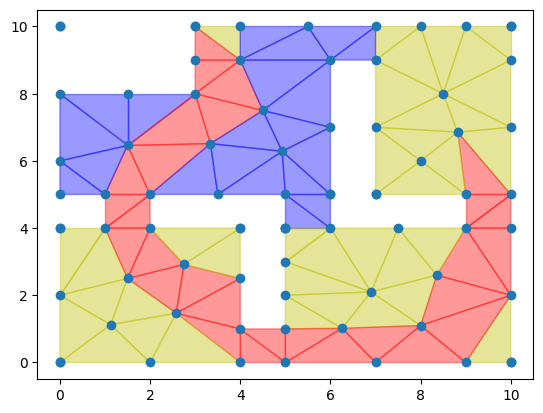

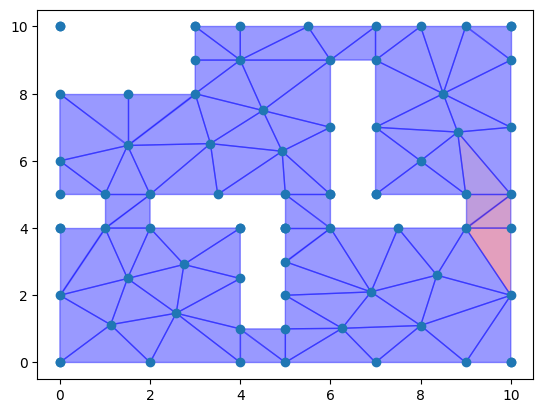

In [21]:
viz_mesh(vert, faces, rois, highlight=prefix_path)
HTML(animate_path(vert, faces, prefix_path).to_html5_video())

### Suffix

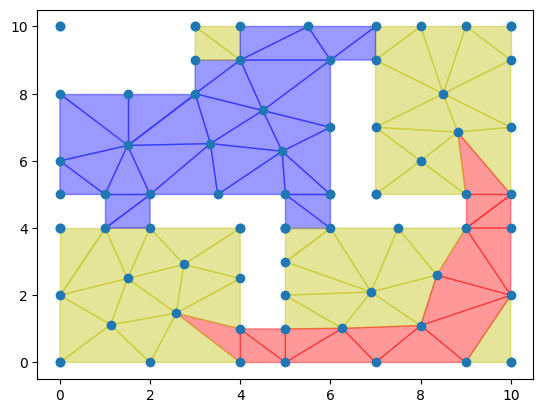

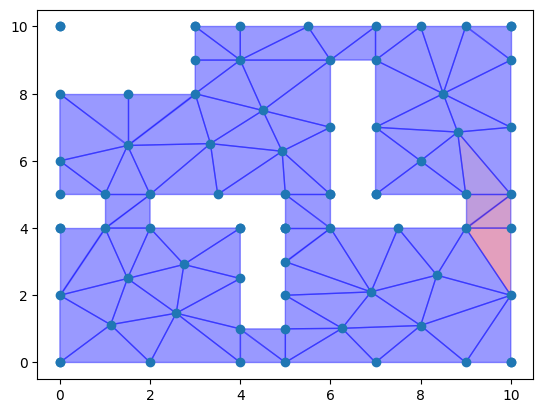

In [22]:
viz_mesh(vert, faces, rois, highlight=suffix_path)
HTML(animate_path(vert, faces, suffix_path).to_html5_video())

# C-Level

In this section, we will expand our existing model of the environment with travel costs.

## Expanding the Model

### Theory - Weighted Transition Systems
A weighted, labelled transition system is defined as a tuple

$$T=(S, Act, \xrightarrow{}, s_0, \mathit{AP}, L, w)$$
where
* $S$ is a finite set of states,
* $Act$ is a finite set of inputs,
* $\xrightarrow{} : S \times Act \times S$ is the transition function,  
* $s_0$ is the initial state,
* $\mathit{AP}$ is a finite set of atomic propositions,
* $L : S \xrightarrow{} 2^{\mathit{AP}}$ is a state labeling function and
* $w: S \times \mathit{Act} \xrightarrow{} \mathbb{R}^+$ is the weight function.

Except for the weight function, this is identical to a regular Transition System. The weight function assigns each edge a cost. For this tutorial, we restrict ourself for **positive** values for the weight function.

### Regions of Different Cost

Here, we define a new set of regions of interest with a new region somewhere in the center that is very costly to go through (so our future plan will navigate around it). The default cost per unit is 1.

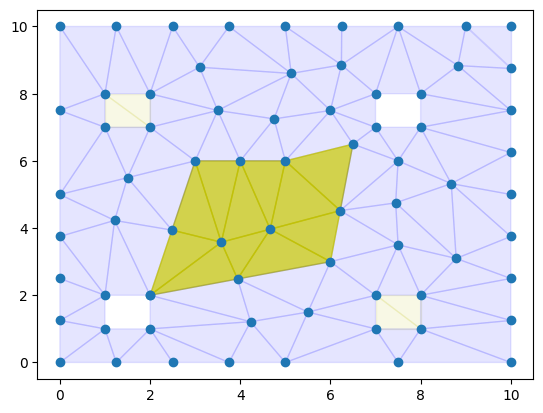

In [44]:
# define regions of interest
rois_w = [
    RegionOfInterest(
        name="obs1",
        points=[(1,1), (1,2), (2,2), (2,1)],
        hole=(1.5,1.5)
    ),
    RegionOfInterest(
        name="obs2",
        points=[(8,8), (7,8), (7,7), (8,7)],
        hole=(7.5,7.5)
    ),
    RegionOfInterest(
        name="goal1",
        points=[(1,7), (1,8), (2,8), (2,7)],
    ),
    RegionOfInterest(
        name="goal2",
        points=[(8,2), (7,2), (7,1), (8,1)],
    ),
    RegionOfInterest(
        name="center",
        points=[(2,2), (3,6), (5,6), (6.5,6.5), (6,3)],
        cost_per_unit=10.0
    ),
]

# define workspace bounds
xmin = 0
xmax = 10
ymin = 0
ymax = 10

# create input file
workspace_to_poly_file(xmin, xmax, ymin, ymax, regions=rois_w)
# call triangle
max_area = 1.5 #@param {type:"slider", min:0.1, max:5.0, step:0.1}
call_triangle(max_area=max_area)
# parse output
vert_w, faces_w = parse_triangle()
# vizualize the result
viz_mesh(vert_w, faces_w, rois_w)

### Exercise - Create a Weighted Transition System

**Exercise:**
* With these new regions, create a new triangulation.
* Create a new Transition Sytem, but include costs on edges this time.
* Make sure you correctly factor in the "length" of the transition between two faces into the cost. Big distances should somehow incur bigger costs. There are a lot of ways to model this, so choose your own and motivate the choice.

**Hints:**
* You can store data to edges: `ts.add_edge(s1, s2, cost=7.3)`
* You can call data stored on edges: `ts.edges[s1, s2]["cost"]`
* A starting point for distance computations could be the distance of face centroids.
* Don't forget to also label your states, just like before!

In [45]:
import networkx as nx
import numpy as np
import math

"""
C-PART
EXERCISE #1 : WEIGHTED TRANSITION SYSTEM
"""

def wts_from_vert(vert, faces, rois):
  wts = nx.DiGraph()
  # fill the WTS
  for id, face in enumerate(faces):
    wts.add_node(id, face = face)

  # Add vertices before calling function
  wts.graph['vertices'] = vert

  # Labelling for each node
  for node in wts.nodes:
    face = wts.nodes[node]['face'] # extract vertex indices
    # index out the vertices and create a polygon of all the vertices for one face (3 faces, 2 vertices each: 6 vertices)
    vertices = [wts.graph['vertices'][indx] for indx in face]
    poly_face = Polygon(vertices) # create polygon and check in which region its contained
    # node can have multiple regions
    wts.nodes[node]["AP"] = [] # create empty list for AP --> regions for each face // can be multiple regions
    cpu_node = []
    for roi in rois:
      if roi.poly.contains(poly_face):
        wts.nodes[node]["AP"].append(roi.name)
        cpu_node.append(roi.cpu)
    if cpu_node:
      wts.nodes[node]["cpu"] = max(cpu_node) # give each node the highest cpu cost of the regions it belongs to
    else:
      wts.nodes[node]["cpu"] = 0 # if no region is found, set cpu to 1

  for node in wts.nodes:
    wts.graph["init"] = node
    break

  wts.graph["AP"] = []
  for roi in rois:
    wts.graph["AP"].append(roi.name)

  # Add edges & edge costs

  def distance2edge(node_a, node_b):
    # recall that these are faces so list of indices to vertices
    poly_a = Polygon([wts.graph['vertices'][indx] for indx in wts.nodes[node_a]['face']])
    poly_b = Polygon([wts.graph['vertices'][indx] for indx in wts.nodes[node_b]['face']])
    poly_a_centroid = poly_a.centroid
    poly_b_centroid = poly_b.centroid

    # compute distance between centroids
    distance = abs(poly_a_centroid.distance(poly_b_centroid))
    distance = math.sqrt((poly_a_centroid.x - poly_b_centroid.x)**2 + (poly_a_centroid.y - poly_b_centroid.y)**2)
    # print(distance)
    return distance

  # Edge Cost calculation
  for node_a in wts.nodes:
    face_a = wts.nodes[node_a]['face'] # extract vertex indices
    for node_b in wts.nodes:
      face_b = wts.nodes[node_b]["face"] # extract vertex indices

      common_vertices = sum(val in face_b for val in face_a)
      # Check cpu cost of region// default = 1 so multiplication
      cpu = max([wts.nodes[node_a]["cpu"], wts.nodes[node_b]["cpu"]])
      # Add edge cost & incoroporate cpu cost
      if common_vertices >=2:
        wts.add_edge(node_a, node_b, cost = distance2edge(node_a, node_b)*cpu)


  return wts

### Exercise - Product Automaton with Weights

**Exercise:**
* Extend your product automaton code to include edge weights.

In [46]:
"""
C-PART
EXERCISE #2 : PRODUCT AUTOMATION WITH WEIGHTS
"""

def weighted_product_automaton(wts, nba):
  weight_prod = nx.DiGraph()
  weight_prod.graph["accept"] = []

  # queue of open states
  que = queue.Queue()
  prod_init = (wts.graph["init"], nba.graph["init"])
  weight_prod.graph["init"] = prod_init
  weight_prod.add_node(prod_init)
  que.put(prod_init)

  # work the queue
  Verbose = False
  counter = 0
  counter2 = 0
  counter3 = 0
  count_val = 6
  while not que.empty():
    weight_prod_from = que.get()
    wts_from = weight_prod_from[0]
    nba_from = weight_prod_from[1]

    for wts_to in wts[wts_from]:
      ts_dictionary = {key: False for key in wts.graph["AP"]}
      for AP in wts.nodes[wts_to]["AP"]:
        ts_dictionary[AP] = True

      if counter <count_val and Verbose:
        print(wts[wts_from])
        print(wts_to)
        print(wts.nodes[wts_to]['AP'])
        print(ts_dictionary) # after it was set to true already
        counter +=1

      for nba_to in nba[nba_from]:
        nba_label = nba[nba_from][nba_to]["guard"]
        if counter2 < count_val and Verbose:
          counter2 +=1
          print(nba[nba_from])
          print(nba_to)
          print("nba_label:", nba_label)

        if nba_label.subs(ts_dictionary):
          if counter3 < count_val and Verbose:
            counter3 +=1
            print("guard exists")
            print(nba_label)
          weight_prod_to = (wts_to, nba_to)
          if not weight_prod.has_node(weight_prod_to):
            que.put(weight_prod_to)
            weight_prod.add_node(weight_prod_to)
          weight_prod.add_edge(weight_prod_from, weight_prod_to, cost = wts.edges[wts_from, wts_to]["cost"])

    if nba_from in nba.graph["accept"]:
      weight_prod.graph["accept"].append(weight_prod_from)

  return weight_prod

## Minimal Paths

In order to find a "good" plan for the autonomous system, we can think of a path that minimizes cost. Since our paths will be infinite, the sum of all transition costs will always be infinite. Here, we compute prefixes and suffixes of minimal length and use the shortest suffix as the arbiter of lasso path choice.

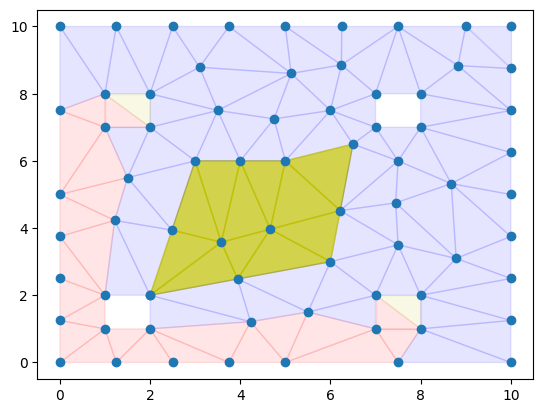

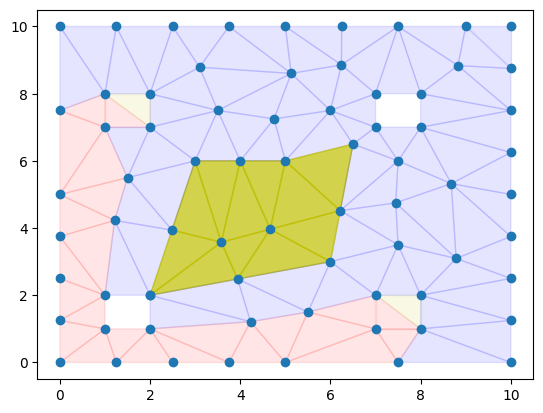

In [47]:
wts = wts_from_vert(vert_w, faces_w, rois_w)
nba = ltl_to_nba("(G F goal1) && (G F goal2)")
prod_w = weighted_product_automaton(wts, nba)

suffixes = min_suffixes(prod_w, weight="cost")
prefixes = min_prefixes(prod_w, weight="cost")
acc_state = min(suffixes, key=suffixes.get)
prefix_path = [state[0] for state in prefixes[acc_state]]
suffix_path = [state[0] for state in suffixes[acc_state]]

viz_mesh(vert_w, faces_w, rois_w, highlight=prefix_path)
viz_mesh(vert_w, faces_w, rois_w, highlight=suffix_path)

# A-Level

So far, this tutorial provided simple-to-understand and simple-to-read solutions to find lasso paths in the product automaton. However, the provided methods are not very efficient. While this does not matter much for the examples of this lab, efficient algorithms are necessary for bigger product automata.

Nested Depth-First-Search [4] is a suitable and efficient algorithm to find accepting cycles in the product. Your task is to implement nested DFS and use it to find lasso paths in the **unweighted** product automaton from the E-level.

## Theory - Basic Depth-First Search

You might already know basic DFS, a classic graph traversal or search algorithm. It can be used to find a path from a starting state to any desired goal state.
```
proc dfs1(s)
  add s to Stack
  add s to States
  for each transition (s,a,s’) do
    add {s,a,s’} to Transitions
    if s’ not in States then dfs1(s’) fi
  od
  delete s from Stack
end
```

## Theory - Nested Depth-First Search

Nested Depth-First Search [4] is the same algorithm, but for lasso paths. After reaching a state in dfs1, it tries to find a cycle from that path.

```
proc dfs1(s)
  add s to Stack1
  add s to States1
  if accepting(s) then States2:=empty; seed:=s; dfs2(s) fi
  for each transition (s,a,s’) do
    add {s,a,s’} to Transitions
    if s’ not in States1 then dfs1(s’) fi
  od
  delete s from Stack1
end

proc dfs2(s) /* the nested search */
  add s to Stack2
  add s to States2
  for each transition (s,a,s’) do
    add {s,a,s’} to Transitions2
    if s’ == seed then report cycle
    else if s’ not in States2 then dfs2(s’) fi
  od
  delete s from Stack2
end
```
Pseudocode taken from [[here]](https://www.win.tue.nl/~dragan/Thesis/PDF/Chapter7.pdf). The link also provides further explanation to the algorithm.

### Exercise - Product Automaton

**Exercise:**
* Make yourself familiar with the Nested DFS algorithm. Use any sources you deem appropriate.
* Document the sources you used to understand the algorithm.
* Implement the Nested DFS search.
* Compare the lasso paths your implementation with the ones found in the E-level.

**Hints:**
* [2] has good explanation for the nested DFS algorithm, but for the dual use-case of verification. They try to show that no lasso path exists, so a lasso path is called a counterexample.

In [48]:
from copy import deepcopy

"""
A-PART
EXERCISE #1 - NESTED DEPTH FIRST SEARCH & VERIFICATION
Suffix: describes the loop at the end of the lasso --> dfs2 : transitions2
Prefix: goes from the start of the lasso to the knot
"""

def dfs2(node, graph, states2= [], stack2 = [], transitions2 = [], seed = None):
    # Add node to states list and stack
    states2.append(node)
    stack2.append(node)
    if not transitions2:
      # Append first starting node
      transitions2.append(node)

    # For each transition state add successor to transition lists
    for successor in graph.successors(node):
        # print("transitions2", transitions2)
        transitions2.append(successor)
        # If successor equal to seed then report cycle
        if successor == seed:
            print(f"Cycle found, successsor: {successor}")
            return transitions2
        elif successor not in states2:
            # Call dfs2 recursively
            # dfs2 will sometimes output NONEs, which cannot be handless by .pop so give new variable name
            suff_return = dfs2(successor, graph, states2, stack2, transitions2, seed)
            if suff_return is not None:
              # Once a cycle has been found, return the transitions/ suffix again and again until returned back in DFS1
              # If suff_return returns None, go back in the tree and check for other susccessors if there will be a cycle
              return suff_return
        # print("transitions2 pre pop:", transitions2)
        transitions2.pop()
    # Delete s from stack2
    stack2.pop()
    return None


def dfs1(node, graph, states1 = [], stack1 = [], transitions = [], prefixes = {}, suffixes = {}):
    # Add node to states list and stack
    states1.append(node)
    stack1.append(node)
    if not transitions:
        # Append first starting init node to transitions list if list is empty
        transitions.append(node)

    # If accepting state, empty states2, initiate seed and call dfs2
    if node in graph.graph["accept"]:
        # If accepting state, append to prefix path
        prefixes[node] = deepcopy(transitions)
        states2 = []
        seed = node # seed is the accepting state, check for cycles in DFS2
        suff_return = dfs2(node, graph, states2, stack2 = [], transitions2 = [], seed= seed)
        if suff_return is not None:
          suffixes[node] = suff_return

    # For each transition add successor to transitions list
    for successor in graph.successors(node):
        # print("transition after append", transitions)
        transitions.append(successor)
        if successor not in states1:
            # Call dfs1 recursively
            suffixes, prefixes = dfs1(successor, graph, states1, stack1, transitions)
        transitions.pop() # Pop to omit duplicates
    # Delete s from stack1
    stack1.pop()
    return suffixes, prefixes

In [49]:
suffixes_final, prefixes_final = dfs1(prod.graph["init"], prod)
for key in suffixes_final:
  print(suffixes_final[key],"\n")


Cycle found, successsor: (82, 'accept_S3')
Cycle found, successsor: (38, 'accept_S3')
Cycle found, successsor: (39, 'accept_S3')
[(82, 'accept_S3'), (30, 'T0_init'), (82, 'T0_init'), (36, 'T0_init'), (34, 'T0_init'), (67, 'T0_init'), (74, 'T0_init'), (5, 'T0_init'), (20, 'T0_init'), (37, 'T0_init'), (38, 'T0_init'), (33, 'T0_init'), (41, 'T0_init'), (26, 'T0_init'), (24, 'T0_init'), (12, 'T0_init'), (58, 'T0_init'), (29, 'T0_init'), (14, 'T0_init'), (15, 'T0_init'), (8, 'T0_init'), (6, 'T1_S1'), (3, 'T1_S1'), (40, 'T1_S1'), (66, 'T1_S1'), (9, 'T1_S1'), (64, 'T1_S1'), (42, 'T1_S1'), (10, 'T1_S1'), (59, 'T1_S1'), (11, 'T1_S1'), (7, 'T1_S1'), (61, 'T1_S1'), (82, 'T1_S1'), (30, 'T1_S1'), (83, 'T1_S1'), (0, 'T1_S1'), (72, 'T1_S1'), (75, 'T1_S1'), (73, 'T1_S1'), (39, 'T1_S1'), (43, 'T1_S1'), (51, 'T1_S1'), (76, 'T2_S2'), (44, 'T2_S2'), (57, 'T2_S2'), (2, 'T2_S2'), (71, 'T2_S2'), (50, 'T2_S2'), (63, 'T2_S2'), (52, 'T2_S2'), (55, 'T2_S2'), (45, 'T2_S2'), (47, 'T2_S2'), (46, 'T2_S2'), (22, 'T2_

In [50]:
"""
A vs E Part
Compare prefix and suffix lengths.

"""
print("NDFS Prefixes:", prefixes_final)
print("NDFS Suffixes:", suffixes_final, "\n")
print("Lasso Prefixes:", prefixes)
print("Lasso Suffixes:", suffixes)

NDFS Prefixes: {(82, 'accept_S3'): [(23, 'T0_init'), (21, 'T0_init'), (16, 'T0_init'), (49, 'T0_init'), (32, 'T0_init'), (54, 'T0_init'), (25, 'T0_init'), (26, 'T0_init'), (24, 'T0_init'), (12, 'T0_init'), (58, 'T0_init'), (29, 'T0_init'), (14, 'T0_init'), (15, 'T0_init'), (8, 'T0_init'), (6, 'T1_S1'), (3, 'T1_S1'), (40, 'T1_S1'), (66, 'T1_S1'), (9, 'T1_S1'), (64, 'T1_S1'), (42, 'T1_S1'), (10, 'T1_S1'), (59, 'T1_S1'), (11, 'T1_S1'), (7, 'T1_S1'), (61, 'T1_S1'), (82, 'T1_S1'), (30, 'T1_S1'), (83, 'T1_S1'), (0, 'T1_S1'), (72, 'T1_S1'), (75, 'T1_S1'), (73, 'T1_S1'), (39, 'T1_S1'), (43, 'T1_S1'), (51, 'T1_S1'), (76, 'T2_S2'), (44, 'T2_S2'), (57, 'T2_S2'), (2, 'T2_S2'), (71, 'T2_S2'), (50, 'T2_S2'), (63, 'T2_S2'), (52, 'T2_S2'), (55, 'T2_S2'), (45, 'T2_S2'), (47, 'T2_S2'), (46, 'T2_S2'), (22, 'T2_S2'), (23, 'T2_S2'), (21, 'T2_S2'), (16, 'T2_S2'), (49, 'T2_S2'), (32, 'T2_S2'), (54, 'T2_S2'), (25, 'T2_S2'), (26, 'T2_S2'), (24, 'T2_S2'), (12, 'T2_S2'), (58, 'T2_S2'), (29, 'T2_S2'), (14, 'T2_S2

In [51]:
print(prod.graph['accept'])

[(39, 'accept_S3'), (38, 'accept_S3'), (82, 'accept_S3')]


Suffix & Prefix Graph for Accepting State (39, 'accept_S3')

Suffix Graph Lasso:


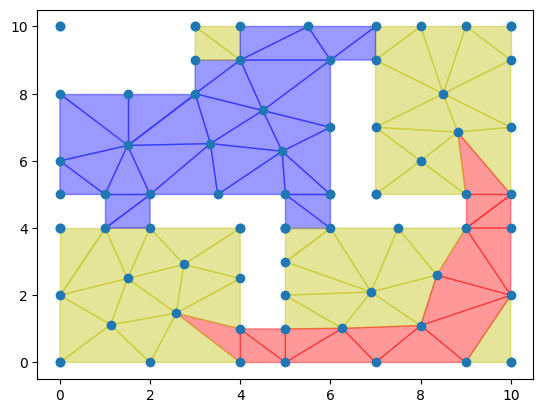


Suffix Graph NDFS:


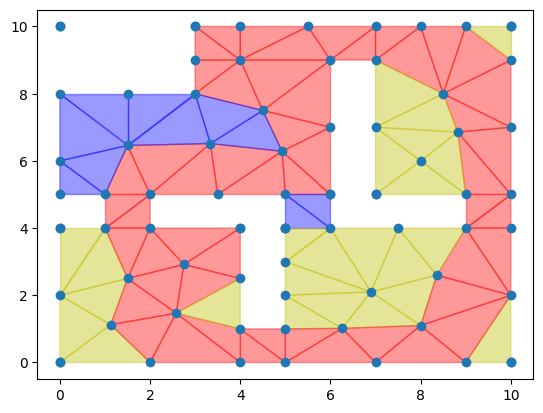


Prefix Graph Lasso:


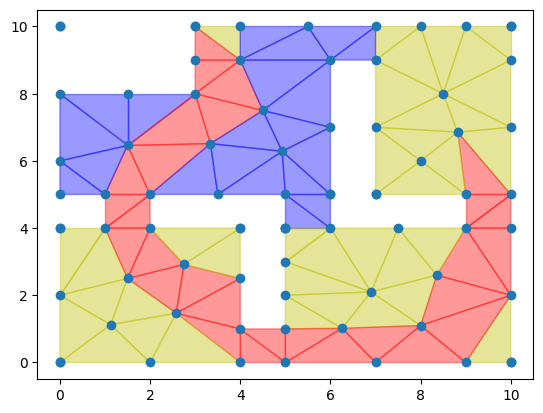


Prefix Graph NDFS:


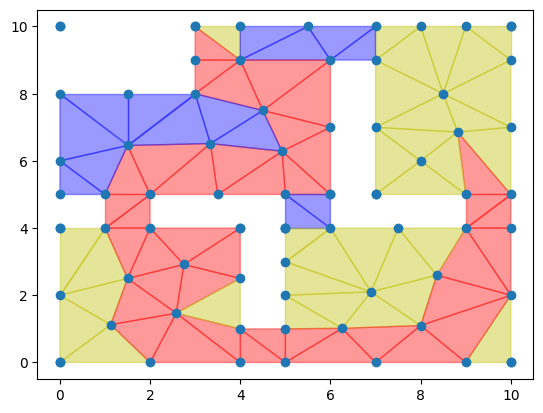



Suffix & Prefix Graph for Accepting State (38, 'accept_S3')

Suffix Graph Lasso:


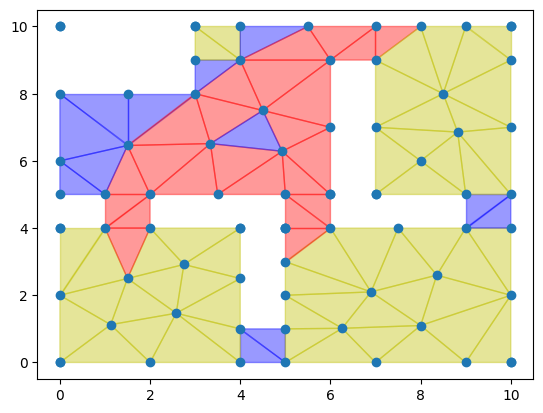


Suffix Graph NDFS:


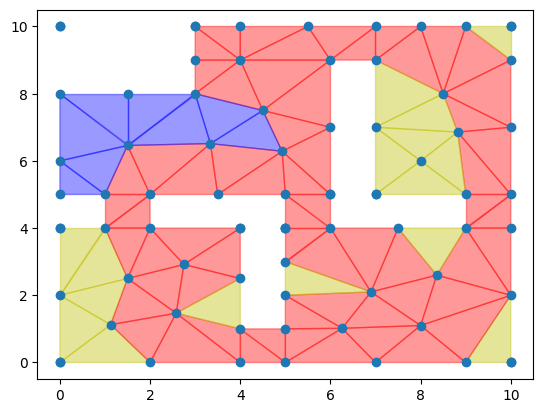


Prefix Graph Lasso:


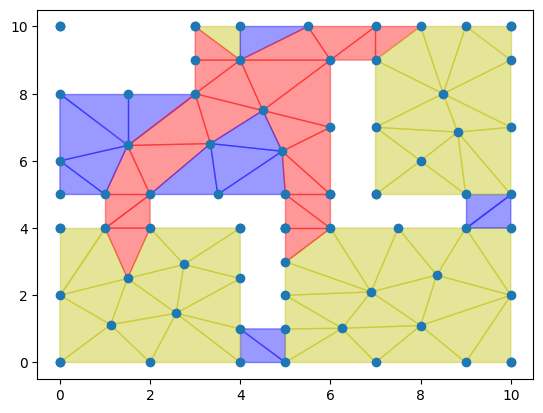


Prefix Graph NDFS:


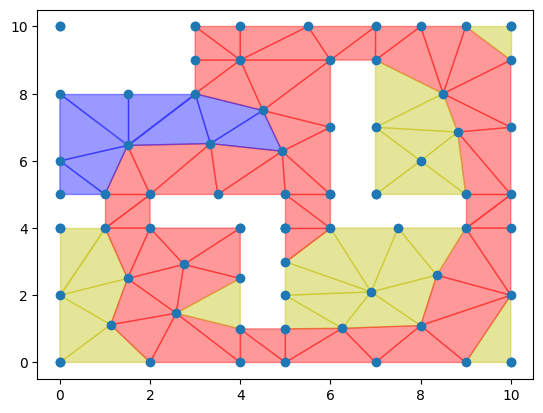



Suffix & Prefix Graph for Accepting State (82, 'accept_S3')

Suffix Graph Lasso:


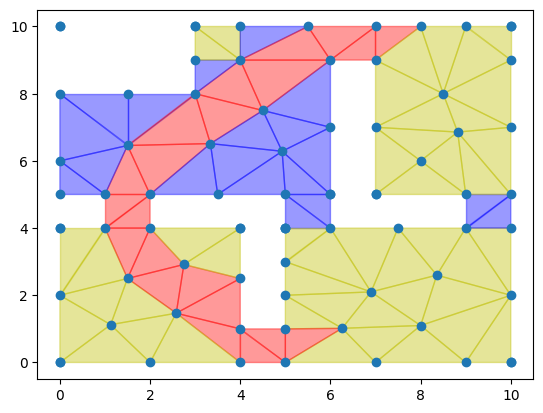


Suffix Graph NDFS:


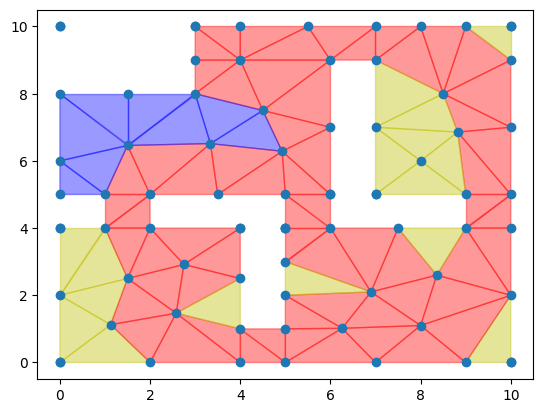


Prefix Graph Lasso:


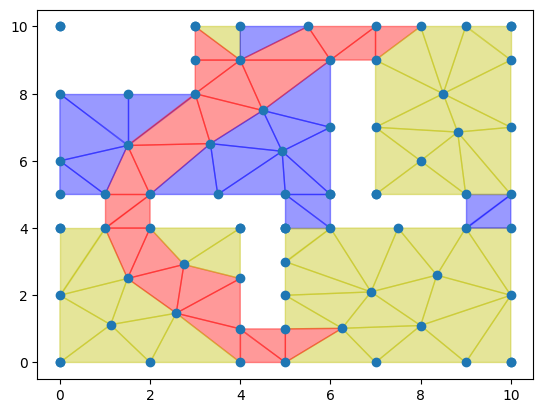


Prefix Graph NDFS:


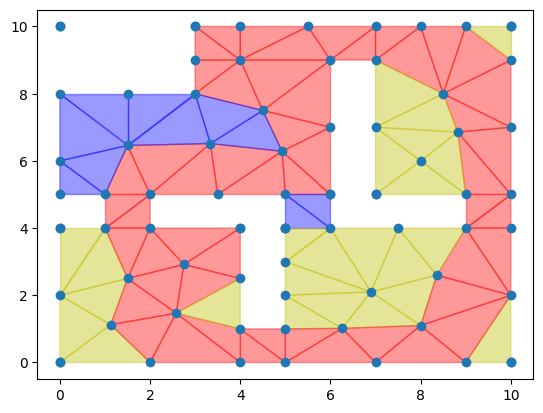

In [55]:
# Visualize
for accepting_state in prod.graph['accept']:
  suffix_path_NDFS = [state[0] for state in suffixes_final[accepting_state]]
  prefix_path_NDFS = [state[0] for state in prefixes_final[accepting_state]]
  suffix_lasso = [state[0] for state in suffixes[accepting_state]]
  prefix_lasso = [state[0] for state in prefixes[accepting_state]]
  print(f"Suffix & Prefix Graph for Accepting State {accepting_state}")
  print("\nSuffix Graph Lasso:")
  viz_mesh(vert, faces, rois, highlight = suffix_lasso)
  print("\nSuffix Graph NDFS:")
  viz_mesh(vert, faces, rois, highlight = suffix_path_NDFS)
  print("\nPrefix Graph Lasso:")
  viz_mesh(vert, faces, rois, highlight = prefix_lasso)
  print("\nPrefix Graph NDFS:")
  viz_mesh(vert, faces, rois, highlight = prefix_path_NDFS)
  print("\n")
# viz_mesh(vert, faces, rois)

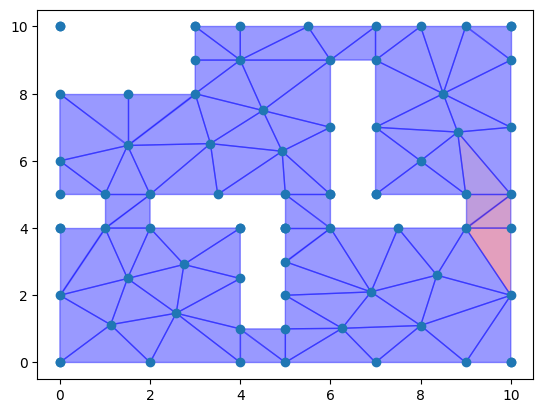

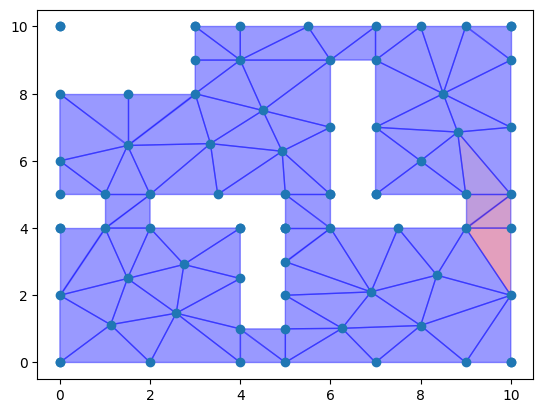

In [56]:
# Animations
accepting_state_0 = prod.graph['accept'][0]
suffix_path_NDFS_0 = [state[0] for state in suffixes_final[accepting_state_0]]
prefix_path_NDFS_0 = [state[0] for state in prefixes_final[accepting_state_0]]
HTML(animate_path(vert, faces, suffix_path_NDFS_0).to_html5_video())
HTML(animate_path(vert, faces, prefix_path_NDFS_0).to_html5_video())


# References

* **[1]** Pnueli, Amir. "The temporal logic of programs." 18th Annual Symposium on Foundations of Computer Science (sfcs 1977). ieee, 1977.
* **[2]** Baier, Christel, and Joost-Pieter Katoen. Principles of model checking. MIT press, 2008.
* **[3]** T. Babiak, M. Křetínský, V. Řehák, and J. Strejček: LTL to Büchi Automata Translation: Fast and More Deterministic, in Proceedings of TACAS 2012, volume 7214 of LNCS, pages 95-109. Springer-Verlag, 2012.
* **[4]** [[PDF]](https://spinroot.com/gerard/pdf/inprint/spin96.pdf) Holzmann, Gerard J., Doron A. Peled, and Mihalis Yannakakis. "On nested depth first search." The Spin Verification System 32 (1996): 81-89.